## LangGraph Open Deep Research Unrolled

In this notebook, we'll look at the unrolled version of the Open Deep Research graph.

You can visit this repository to see the original application: [Open Deep Research](https://github.com/langchain-ai/open_deep_research)

Let's jump in!

## What We're Building

![image](https://i.imgur.com/YzbY9vJ.png)

Dependencies: 

You'll need two different API keys for the default method - though you can customize this graph to your heart's content!

In [1]:
import os
import getpass

os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter your Anthropic API key: ")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

## Task 1: State

The state structure organizes all the information needed to generate and refine a report on a given topic through multiple steps. Here’s a breakdown:

- **Report-Level State:**  
  - **Topic:** The overall subject of the report.  
  - **Feedback on Report Plan:** Comments or evaluations on the preliminary report outline.  
  - **Sections:** A list of individual report sections (each with its own name, description, whether research is needed, and content).  
  - **Completed Sections:** A collection of sections that have been fully developed, which is also used by downstream processes (e.g., a Send() API).  
  - **Research-Based Content:** A string that gathers content produced from web research, which may be integrated into the final report.  
  - **Final Report:** The completed report after all sections and revisions are combined.

- **Section-Level State:**  
  For each report section, the state captures:  
  - **Section Details:** Including the section’s name, a brief overview (description), a flag indicating if web research should be performed, and the actual content.  
  - **Search Process:** The number of search iterations that have been executed and a list of search queries used to gather information.  
  - **Source Content:** A formatted string containing the relevant material obtained from web searches.  
  - **Integration:** Both the research-derived content and the list of fully completed sections are tracked to ensure they can be merged into the overall report.

- **Search Queries and Feedback:**  
  - **Search Queries:** Represented as individual query objects, these encapsulate the strings used to perform web searches.  
  - **Feedback:** After generating parts of the report, feedback is provided as a grade (either "pass" or "fail") along with any follow-up queries to improve the work.

In [2]:
from typing import Annotated, List, TypedDict, Literal
from pydantic import BaseModel, Field
import operator

class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    research: bool = Field(
        description="Whether to perform web research for this section of the report."
    )
    content: str = Field(
        description="The content of the section."
    )   

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries.",
    )

class Feedback(BaseModel):
    grade: Literal["pass","fail"] = Field(
        description="Evaluation result indicating whether the response meets requirements ('pass') or needs revision ('fail')."
    )
    follow_up_queries: List[SearchQuery] = Field(
        description="List of follow-up search queries.",
    )

class ReportStateInput(TypedDict):
    topic: str # Report topic
    
class ReportStateOutput(TypedDict):
    final_report: str # Final report

class ReportState(TypedDict):
    topic: str # Report topic    
    feedback_on_report_plan: str # Feedback on the report plan
    sections: list[Section] # List of report sections 
    completed_sections: Annotated[list, operator.add] # Send() API key
    report_sections_from_research: str # String of any completed sections from research to write final sections
    final_report: str # Final report

class SectionState(TypedDict):
    topic: str # Report topic
    section: Section # Report section  
    search_iterations: int # Number of search iterations done
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # String of any completed sections from research to write final sections
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API


## Task 2: Utilities and Helpers

We have a number of utility functions that we'll use to build our graph. Let's take a look at them.

In [3]:
import os
import asyncio
import requests

from tavily import TavilyClient, AsyncTavilyClient
from langchain_community.retrievers import ArxivRetriever
from langchain_community.utilities.pubmed import PubMedAPIWrapper
from exa_py import Exa
from typing import List, Optional, Dict, Any
from langsmith import traceable

tavily_client = TavilyClient()
tavily_async_client = AsyncTavilyClient()

This function is a small helper that makes sure your configuration values are in a consistent format. If you pass in a string, it simply returns that string. However, if you pass in an enum (a special type of value), it will extract and return the underlying value of that enum. This helps when your configuration might come in different types but you need to work with strings consistently.

In [4]:
def get_config_value(value):
    """
    Helper function to handle both string and enum cases of configuration values
    """
    return value if isinstance(value, str) else value.value

This function filters a configuration dictionary so that it only includes parameters that are allowed for a specific search API. It works by looking up a list of accepted parameter names for the given API (like “exa” or “pubmed”) and then stripping out any other entries from the configuration. If no configuration is provided, it simply returns an empty dictionary. This ensures that only valid and expected parameters are sent to the API.

In [5]:
# Helper function to get search parameters based on the search API and config
def get_search_params(search_api: str, search_api_config: Optional[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Filters the search_api_config dictionary to include only parameters accepted by the specified search API.

    Args:
        search_api (str): The search API identifier (e.g., "exa", "tavily").
        search_api_config (Optional[Dict[str, Any]]): The configuration dictionary for the search API.

    Returns:
        Dict[str, Any]: A dictionary of parameters to pass to the search function.
    """
    # Define accepted parameters for each search API
    SEARCH_API_PARAMS = {
        "exa": ["max_characters", "num_results", "include_domains", "exclude_domains", "subpages"],
        "tavily": [],  # Tavily currently accepts no additional parameters
        "perplexity": [],  # Perplexity accepts no additional parameters
        "arxiv": ["load_max_docs", "get_full_documents", "load_all_available_meta"],
        "pubmed": ["top_k_results", "email", "api_key", "doc_content_chars_max"],
    }

    # Get the list of accepted parameters for the given search API
    accepted_params = SEARCH_API_PARAMS.get(search_api, [])

    # If no config provided, return an empty dict
    if not search_api_config:
        return {}

    # Filter the config to only include accepted parameters
    return {k: v for k, v in search_api_config.items() if k in accepted_params}

This function takes a collection of search results—possibly from several responses—and formats them into a neat, human-readable string. It starts by combining all the results and then removes any duplicates (using the URL to check for repeats). For each unique source, it prints out the title, URL, and a summary of the content. If enabled, it also includes a trimmed version of the full source content, ensuring that the text does not exceed a specified token limit. This results in a clean, consolidated overview of your search results.

In [6]:
def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=True):
    """
    Takes a list of search responses and formats them into a readable string.
    Limits the raw_content to approximately max_tokens_per_source.
 
    Args:
        search_responses: List of search response dicts, each containing:
            - query: str
            - results: List of dicts with fields:
                - title: str
                - url: str
                - content: str
                - score: float
                - raw_content: str|None
        max_tokens_per_source: int
        include_raw_content: bool
            
    Returns:
        str: Formatted string with deduplicated sources
    """
     # Collect all results
    sources_list = []
    for response in search_response:
        sources_list.extend(response['results'])
    
    # Deduplicate by URL
    unique_sources = {source['url']: source for source in sources_list}

    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
                
    return formatted_text.strip()


Designed to help organize documentation or reports, this function takes a list of section objects and turns them into a well-formatted string. For each section, it prints a header with the section number and name, followed by its description, any research notes, and the main content (or a placeholder if the content isn’t written yet). The output is clearly separated by visual dividers, making it easy to read and understand the structure of the document.

In [7]:
def format_sections(sections: list[Section]) -> str:
    """ Format a list of sections into a string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{'='*60}
Section {idx}: {section.name}
{'='*60}
Description:
{section.description}
Requires Research: 
{section.research}

Content:
{section.content if section.content else '[Not yet written]'}

"""
    return formatted_str

This function performs multiple web searches concurrently using the Tavily API. You simply provide it with a list of search queries, and it creates asynchronous tasks for each one. The function then gathers all the responses together, each containing details like the title, URL, snippet of content, and optionally the raw content. This is particularly useful when you need to search several queries at once without waiting for each one to finish sequentially.

In [8]:
@traceable
async def tavily_search_async(search_queries):
    """
    Performs concurrent web searches using the Tavily API.

    Args:
        search_queries (List[SearchQuery]): List of search queries to process

    Returns:
            List[dict]: List of search responses from Tavily API, one per query. Each response has format:
                {
                    'query': str, # The original search query
                    'follow_up_questions': None,      
                    'answer': None,
                    'images': list,
                    'results': [                     # List of search results
                        {
                            'title': str,            # Title of the webpage
                            'url': str,              # URL of the result
                            'content': str,          # Summary/snippet of content
                            'score': float,          # Relevance score
                            'raw_content': str|None  # Full page content if available
                        },
                        ...
                    ]
                }
    """
    
    search_tasks = []
    for query in search_queries:
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="general"
                )
            )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)

    return search_docs

This function leverages the Perplexity API to perform web searches. For every query provided, it sends a request with a prompt to fetch factual content. The response is parsed to extract the main answer and any associated citations. The first citation contains the full content, while any additional citations serve as secondary sources. The results are then packaged into a standardized structure, making it clear which source provides the complete information and which ones are supporting references.

In [9]:
@traceable
def perplexity_search(search_queries):
    """Search the web using the Perplexity API.
    
    Args:
        search_queries (List[SearchQuery]): List of search queries to process
  
    Returns:
        List[dict]: List of search responses from Perplexity API, one per query. Each response has format:
            {
                'query': str,                    # The original search query
                'follow_up_questions': None,      
                'answer': None,
                'images': list,
                'results': [                     # List of search results
                    {
                        'title': str,            # Title of the search result
                        'url': str,              # URL of the result
                        'content': str,          # Summary/snippet of content
                        'score': float,          # Relevance score
                        'raw_content': str|None  # Full content or None for secondary citations
                    },
                    ...
                ]
            }
    """

    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "Authorization": f"Bearer {os.getenv('PERPLEXITY_API_KEY')}"
    }
    
    search_docs = []
    for query in search_queries:

        payload = {
            "model": "sonar-pro",
            "messages": [
                {
                    "role": "system",
                    "content": "Search the web and provide factual information with sources."
                },
                {
                    "role": "user",
                    "content": query
                }
            ]
        }
        
        response = requests.post(
            "https://api.perplexity.ai/chat/completions",
            headers=headers,
            json=payload
        )
        response.raise_for_status()  # Raise exception for bad status codes
        
        # Parse the response
        data = response.json()
        content = data["choices"][0]["message"]["content"]
        citations = data.get("citations", ["https://perplexity.ai"])
        
        # Create results list for this query
        results = []
        
        # First citation gets the full content
        results.append({
            "title": f"Perplexity Search, Source 1",
            "url": citations[0],
            "content": content,
            "raw_content": content,
            "score": 1.0  # Adding score to match Tavily format
        })
        
        # Add additional citations without duplicating content
        for i, citation in enumerate(citations[1:], start=2):
            results.append({
                "title": f"Perplexity Search, Source {i}",
                "url": citation,
                "content": "See primary source for full content",
                "raw_content": None,
                "score": 0.5  # Lower score for secondary sources
            })
        
        # Format response to match Tavily structure
        search_docs.append({
            "query": query,
            "follow_up_questions": None,
            "answer": None,
            "images": [],
            "results": results
        })
    
    return search_docs

Using the Exa API, this function performs web searches with a lot of flexibility. It allows you to limit the number of characters retrieved for each result, specify how many results you want, and even control which domains to include or exclude. If you need more detail, it can also fetch additional subpages related to each result. The function processes each query (while handling rate limits), deduplicates the results by their URL, and combines elements like summaries and text into a single, formatted output.

In [10]:
@traceable
async def exa_search(search_queries, max_characters: Optional[int] = None, num_results=5, 
                     include_domains: Optional[List[str]] = None, 
                     exclude_domains: Optional[List[str]] = None,
                     subpages: Optional[int] = None):
    """Search the web using the Exa API.
    
    Args:
        search_queries (List[SearchQuery]): List of search queries to process
        max_characters (int, optional): Maximum number of characters to retrieve for each result's raw content.
                                       If None, the text parameter will be set to True instead of an object.
        num_results (int): Number of search results per query. Defaults to 5.
        include_domains (List[str], optional): List of domains to include in search results. 
            When specified, only results from these domains will be returned.
        exclude_domains (List[str], optional): List of domains to exclude from search results.
            Cannot be used together with include_domains.
        subpages (int, optional): Number of subpages to retrieve per result. If None, subpages are not retrieved.
        
    Returns:
        List[dict]: List of search responses from Exa API, one per query. Each response has format:
            {
                'query': str,                    # The original search query
                'follow_up_questions': None,      
                'answer': None,
                'images': list,
                'results': [                     # List of search results
                    {
                        'title': str,            # Title of the search result
                        'url': str,              # URL of the result
                        'content': str,          # Summary/snippet of content
                        'score': float,          # Relevance score
                        'raw_content': str|None  # Full content or None for secondary citations
                    },
                    ...
                ]
            }
    """
    # Check that include_domains and exclude_domains are not both specified
    if include_domains and exclude_domains:
        raise ValueError("Cannot specify both include_domains and exclude_domains")
    
    # Initialize Exa client (API key should be configured in your .env file)
    exa = Exa(api_key = f"{os.getenv('EXA_API_KEY')}")
    
    # Define the function to process a single query
    async def process_query(query):
        # Use run_in_executor to make the synchronous exa call in a non-blocking way
        loop = asyncio.get_event_loop()
        
        # Define the function for the executor with all parameters
        def exa_search_fn():
            # Build parameters dictionary
            kwargs = {
                # Set text to True if max_characters is None, otherwise use an object with max_characters
                "text": True if max_characters is None else {"max_characters": max_characters},
                "summary": True,  # This is an amazing feature by EXA. It provides an AI generated summary of the content based on the query
                "num_results": num_results
            }
            
            # Add optional parameters only if they are provided
            if subpages is not None:
                kwargs["subpages"] = subpages
                
            if include_domains:
                kwargs["include_domains"] = include_domains
            elif exclude_domains:
                kwargs["exclude_domains"] = exclude_domains
                
            return exa.search_and_contents(query, **kwargs)
        
        response = await loop.run_in_executor(None, exa_search_fn)
        
        # Format the response to match the expected output structure
        formatted_results = []
        seen_urls = set()  # Track URLs to avoid duplicates
        
        # Helper function to safely get value regardless of if item is dict or object
        def get_value(item, key, default=None):
            if isinstance(item, dict):
                return item.get(key, default)
            else:
                return getattr(item, key, default) if hasattr(item, key) else default
        
        # Access the results from the SearchResponse object
        results_list = get_value(response, 'results', [])
        
        # First process all main results
        for result in results_list:
            # Get the score with a default of 0.0 if it's None or not present
            score = get_value(result, 'score', 0.0)
            
            # Combine summary and text for content if both are available
            text_content = get_value(result, 'text', '')
            summary_content = get_value(result, 'summary', '')
            
            content = text_content
            if summary_content:
                if content:
                    content = f"{summary_content}\n\n{content}"
                else:
                    content = summary_content
            
            title = get_value(result, 'title', '')
            url = get_value(result, 'url', '')
            
            # Skip if we've seen this URL before (removes duplicate entries)
            if url in seen_urls:
                continue
                
            seen_urls.add(url)
            
            # Main result entry
            result_entry = {
                "title": title,
                "url": url,
                "content": content,
                "score": score,
                "raw_content": text_content
            }
            
            # Add the main result to the formatted results
            formatted_results.append(result_entry)
        
        # Now process subpages only if the subpages parameter was provided
        if subpages is not None:
            for result in results_list:
                subpages_list = get_value(result, 'subpages', [])
                for subpage in subpages_list:
                    # Get subpage score
                    subpage_score = get_value(subpage, 'score', 0.0)
                    
                    # Combine summary and text for subpage content
                    subpage_text = get_value(subpage, 'text', '')
                    subpage_summary = get_value(subpage, 'summary', '')
                    
                    subpage_content = subpage_text
                    if subpage_summary:
                        if subpage_content:
                            subpage_content = f"{subpage_summary}\n\n{subpage_content}"
                        else:
                            subpage_content = subpage_summary
                    
                    subpage_url = get_value(subpage, 'url', '')
                    
                    # Skip if we've seen this URL before
                    if subpage_url in seen_urls:
                        continue
                        
                    seen_urls.add(subpage_url)
                    
                    formatted_results.append({
                        "title": get_value(subpage, 'title', ''),
                        "url": subpage_url,
                        "content": subpage_content,
                        "score": subpage_score,
                        "raw_content": subpage_text
                    })
        
        # Collect images if available (only from main results to avoid duplication)
        images = []
        for result in results_list:
            image = get_value(result, 'image')
            if image and image not in images:  # Avoid duplicate images
                images.append(image)
                
        return {
            "query": query,
            "follow_up_questions": None,
            "answer": None,
            "images": images,
            "results": formatted_results
        }
    
    # Process all queries sequentially with delay to respect rate limit
    search_docs = []
    for i, query in enumerate(search_queries):
        try:
            # Add delay between requests (0.25s = 4 requests per second, well within the 5/s limit)
            if i > 0:  # Don't delay the first request
                await asyncio.sleep(0.25)
            
            result = await process_query(query)
            search_docs.append(result)
        except Exception as e:
            # Handle exceptions gracefully
            print(f"Error processing query '{query}': {str(e)}")
            # Add a placeholder result for failed queries to maintain index alignment
            search_docs.append({
                "query": query,
                "follow_up_questions": None,
                "answer": None,
                "images": [],
                "results": [],
                "error": str(e)
            })
            
            # Add additional delay if we hit a rate limit error
            if "429" in str(e):
                print("Rate limit exceeded. Adding additional delay...")
                await asyncio.sleep(1.0)  # Add a longer delay if we hit a rate limit
    
    return search_docs

This function is tailored for searching academic papers on arXiv. It runs asynchronously, so it can handle multiple queries without blocking. For each search query, it initializes an arXiv retriever that gathers documents along with their metadata (like authors, publication dates, and summaries). The results are then formatted to include useful details such as a link to the paper and even a link to the PDF if available. It also assigns a relevance score to each paper and respects arXiv’s rate limits by adding delays between requests.

In [11]:
@traceable
async def arxiv_search_async(search_queries, load_max_docs=5, get_full_documents=True, load_all_available_meta=True):
    """
    Performs concurrent searches on arXiv using the ArxivRetriever.

    Args:
        search_queries (List[str]): List of search queries or article IDs
        load_max_docs (int, optional): Maximum number of documents to return per query. Default is 5.
        get_full_documents (bool, optional): Whether to fetch full text of documents. Default is True.
        load_all_available_meta (bool, optional): Whether to load all available metadata. Default is True.

    Returns:
        List[dict]: List of search responses from arXiv, one per query. Each response has format:
            {
                'query': str,                    # The original search query
                'follow_up_questions': None,      
                'answer': None,
                'images': [],
                'results': [                     # List of search results
                    {
                        'title': str,            # Title of the paper
                        'url': str,              # URL (Entry ID) of the paper
                        'content': str,          # Formatted summary with metadata
                        'score': float,          # Relevance score (approximated)
                        'raw_content': str|None  # Full paper content if available
                    },
                    ...
                ]
            }
    """
    
    async def process_single_query(query):
        try:
            # Create retriever for each query
            retriever = ArxivRetriever(
                load_max_docs=load_max_docs,
                get_full_documents=get_full_documents,
                load_all_available_meta=load_all_available_meta
            )
            
            # Run the synchronous retriever in a thread pool
            loop = asyncio.get_event_loop()
            docs = await loop.run_in_executor(None, lambda: retriever.invoke(query))
            
            results = []
            # Assign decreasing scores based on the order
            base_score = 1.0
            score_decrement = 1.0 / (len(docs) + 1) if docs else 0
            
            for i, doc in enumerate(docs):
                # Extract metadata
                metadata = doc.metadata
                
                # Use entry_id as the URL (this is the actual arxiv link)
                url = metadata.get('entry_id', '')
                
                # Format content with all useful metadata
                content_parts = []

                # Primary information
                if 'Summary' in metadata:
                    content_parts.append(f"Summary: {metadata['Summary']}")

                if 'Authors' in metadata:
                    content_parts.append(f"Authors: {metadata['Authors']}")

                # Add publication information
                published = metadata.get('Published')
                published_str = published.isoformat() if hasattr(published, 'isoformat') else str(published) if published else ''
                if published_str:
                    content_parts.append(f"Published: {published_str}")

                # Add additional metadata if available
                if 'primary_category' in metadata:
                    content_parts.append(f"Primary Category: {metadata['primary_category']}")

                if 'categories' in metadata and metadata['categories']:
                    content_parts.append(f"Categories: {', '.join(metadata['categories'])}")

                if 'comment' in metadata and metadata['comment']:
                    content_parts.append(f"Comment: {metadata['comment']}")

                if 'journal_ref' in metadata and metadata['journal_ref']:
                    content_parts.append(f"Journal Reference: {metadata['journal_ref']}")

                if 'doi' in metadata and metadata['doi']:
                    content_parts.append(f"DOI: {metadata['doi']}")

                # Get PDF link if available in the links
                pdf_link = ""
                if 'links' in metadata and metadata['links']:
                    for link in metadata['links']:
                        if 'pdf' in link:
                            pdf_link = link
                            content_parts.append(f"PDF: {pdf_link}")
                            break

                # Join all content parts with newlines 
                content = "\n".join(content_parts)
                
                result = {
                    'title': metadata.get('Title', ''),
                    'url': url,  # Using entry_id as the URL
                    'content': content,
                    'score': base_score - (i * score_decrement),
                    'raw_content': doc.page_content if get_full_documents else None
                }
                results.append(result)
                
            return {
                'query': query,
                'follow_up_questions': None,
                'answer': None,
                'images': [],
                'results': results
            }
        except Exception as e:
            # Handle exceptions gracefully
            print(f"Error processing arXiv query '{query}': {str(e)}")
            return {
                'query': query,
                'follow_up_questions': None,
                'answer': None,
                'images': [],
                'results': [],
                'error': str(e)
            }
    
    # Process queries sequentially with delay to respect arXiv rate limit (1 request per 3 seconds)
    search_docs = []
    for i, query in enumerate(search_queries):
        try:
            # Add delay between requests (3 seconds per ArXiv's rate limit)
            if i > 0:  # Don't delay the first request
                await asyncio.sleep(3.0)
            
            result = await process_single_query(query)
            search_docs.append(result)
        except Exception as e:
            # Handle exceptions gracefully
            print(f"Error processing arXiv query '{query}': {str(e)}")
            search_docs.append({
                'query': query,
                'follow_up_questions': None,
                'answer': None,
                'images': [],
                'results': [],
                'error': str(e)
            })
            
            # Add additional delay if we hit a rate limit error
            if "429" in str(e) or "Too Many Requests" in str(e):
                print("ArXiv rate limit exceeded. Adding additional delay...")
                await asyncio.sleep(5.0)  # Add a longer delay if we hit a rate limit
    
    return search_docs

Focused on retrieving biomedical literature, this function performs asynchronous searches on PubMed using a specialized API wrapper. For each query, it fetches a set of documents and processes them to extract important details such as the publication date, copyright information, and a summary of the research. It then constructs a URL for the PubMed entry and organizes everything neatly into a structured response. The function also dynamically adjusts delays between requests to avoid hitting rate limits, ensuring smooth and efficient retrieval of biomedical articles.

In [12]:
@traceable
async def pubmed_search_async(search_queries, top_k_results=5, email=None, api_key=None, doc_content_chars_max=4000):
    """
    Performs concurrent searches on PubMed using the PubMedAPIWrapper.

    Args:
        search_queries (List[str]): List of search queries
        top_k_results (int, optional): Maximum number of documents to return per query. Default is 5.
        email (str, optional): Email address for PubMed API. Required by NCBI.
        api_key (str, optional): API key for PubMed API for higher rate limits.
        doc_content_chars_max (int, optional): Maximum characters for document content. Default is 4000.

    Returns:
        List[dict]: List of search responses from PubMed, one per query. Each response has format:
            {
                'query': str,                    # The original search query
                'follow_up_questions': None,      
                'answer': None,
                'images': [],
                'results': [                     # List of search results
                    {
                        'title': str,            # Title of the paper
                        'url': str,              # URL to the paper on PubMed
                        'content': str,          # Formatted summary with metadata
                        'score': float,          # Relevance score (approximated)
                        'raw_content': str       # Full abstract content
                    },
                    ...
                ]
            }
    """
    
    async def process_single_query(query):
        try:
            # print(f"Processing PubMed query: '{query}'")
            
            # Create PubMed wrapper for the query
            wrapper = PubMedAPIWrapper(
                top_k_results=top_k_results,
                doc_content_chars_max=doc_content_chars_max,
                email=email if email else "your_email@example.com",
                api_key=api_key if api_key else ""
            )
            
            # Run the synchronous wrapper in a thread pool
            loop = asyncio.get_event_loop()
            
            # Use wrapper.lazy_load instead of load to get better visibility
            docs = await loop.run_in_executor(None, lambda: list(wrapper.lazy_load(query)))
            
            print(f"Query '{query}' returned {len(docs)} results")
            
            results = []
            # Assign decreasing scores based on the order
            base_score = 1.0
            score_decrement = 1.0 / (len(docs) + 1) if docs else 0
            
            for i, doc in enumerate(docs):
                # Format content with metadata
                content_parts = []
                
                if doc.get('Published'):
                    content_parts.append(f"Published: {doc['Published']}")
                
                if doc.get('Copyright Information'):
                    content_parts.append(f"Copyright Information: {doc['Copyright Information']}")
                
                if doc.get('Summary'):
                    content_parts.append(f"Summary: {doc['Summary']}")
                
                # Generate PubMed URL from the article UID
                uid = doc.get('uid', '')
                url = f"https://pubmed.ncbi.nlm.nih.gov/{uid}/" if uid else ""
                
                # Join all content parts with newlines
                content = "\n".join(content_parts)
                
                result = {
                    'title': doc.get('Title', ''),
                    'url': url,
                    'content': content,
                    'score': base_score - (i * score_decrement),
                    'raw_content': doc.get('Summary', '')
                }
                results.append(result)
            
            return {
                'query': query,
                'follow_up_questions': None,
                'answer': None,
                'images': [],
                'results': results
            }
        except Exception as e:
            # Handle exceptions with more detailed information
            error_msg = f"Error processing PubMed query '{query}': {str(e)}"
            print(error_msg)
            import traceback
            print(traceback.format_exc())  # Print full traceback for debugging
            
            return {
                'query': query,
                'follow_up_questions': None,
                'answer': None,
                'images': [],
                'results': [],
                'error': str(e)
            }
    
    # Process all queries with a reasonable delay between them
    search_docs = []
    
    # Start with a small delay that increases if we encounter rate limiting
    delay = 1.0  # Start with a more conservative delay
    
    for i, query in enumerate(search_queries):
        try:
            # Add delay between requests
            if i > 0:  # Don't delay the first request
                # print(f"Waiting {delay} seconds before next query...")
                await asyncio.sleep(delay)
            
            result = await process_single_query(query)
            search_docs.append(result)
            
            # If query was successful with results, we can slightly reduce delay (but not below minimum)
            if result.get('results') and len(result['results']) > 0:
                delay = max(0.5, delay * 0.9)  # Don't go below 0.5 seconds
            
        except Exception as e:
            # Handle exceptions gracefully
            error_msg = f"Error in main loop processing PubMed query '{query}': {str(e)}"
            print(error_msg)
            
            search_docs.append({
                'query': query,
                'follow_up_questions': None,
                'answer': None,
                'images': [],
                'results': [],
                'error': str(e)
            })
            
            # If we hit an exception, increase delay for next query
            delay = min(5.0, delay * 1.5)  # Don't exceed 5 seconds
    
    return search_docs

## Report Planner and Configurations

This code defines a configuration system for a chatbot that generates reports. Here's a breakdown of its components:

1. **Default Report Structure:**  
   A multi-line string provides a template for creating reports. It suggests starting with an introduction that gives an overview of the topic, then dividing the main content into sections focused on sub-topics, and finally ending with a conclusion that summarizes the main points.

2. **Enumerated Types (Enums):**  
   - **SearchAPI:** Lists possible search services (like PERPLEXITY, TAVILY, EXA, ARXIV, and PUBMED) that the chatbot might use to gather information.
   - **PlannerProvider & WriterProvider:** These define options for external service providers that handle planning (organizing the report structure) and writing (generating the text). Options include providers like ANTHROPIC, OPENAI, and GROQ.

3. **Configuration Data Class:**  
   The `Configuration` class holds various settings for the chatbot. Key attributes include:
   - **report_structure:** Uses the default report template.
   - **number_of_queries:** Specifies how many search queries should be generated in each iteration (default is 2).
   - **max_search_depth:** Sets the limit for how many times the chatbot can iterate through reflection and search (default is 2).
   - **planner_provider & planner_model:** Determine which external service and model to use for planning the report.
   - **writer_provider & writer_model:** Specify the external service and model for generating the report text.
   - **search_api & search_api_config:** Indicate which search API to use (defaulting to TAVILY) and allow for additional API configuration.

4. **Configuration Initialization Method:**  
   The class method `from_runnable_config` allows the configuration to be created from a provided configuration object (or from environment variables). It checks for values in the environment (using uppercase names) and from a passed configuration dictionary. Only fields with provided values are used to instantiate the `Configuration` object.

In [13]:
import os
from enum import Enum
from dataclasses import dataclass, fields
from typing import Any, Optional, Dict 

from langchain_core.runnables import RunnableConfig
from dataclasses import dataclass

DEFAULT_REPORT_STRUCTURE = """Use this structure to create a report on the user-provided topic:

1. Introduction (no research needed)
   - Brief overview of the topic area

2. Main Body Sections:
   - Each section should focus on a sub-topic of the user-provided topic
   
3. Conclusion
   - Aim for 1 structural element (either a list of table) that distills the main body sections 
   - Provide a concise summary of the report
   
Provide a paragraph with no more than 500 words to describe the key take aways on the topic"""

class SearchAPI(Enum):
    PERPLEXITY = "perplexity"
    TAVILY = "tavily"
    EXA = "exa"
    ARXIV = "arxiv"
    PUBMED = "pubmed"

class PlannerProvider(Enum):
    ANTHROPIC = "anthropic"
    OPENAI = "openai"
    GROQ = "groq"

class WriterProvider(Enum):
    ANTHROPIC = "anthropic"
    OPENAI = "openai"
    GROQ = "groq"

@dataclass(kw_only=True)
class Configuration:
    """The configurable fields for the chatbot."""
    report_structure: str = DEFAULT_REPORT_STRUCTURE # Defaults to the default report structure
    number_of_queries: int = 2 # Number of search queries to generate per iteration
    max_search_depth: int = 2 # Maximum number of reflection + search iterations
    planner_provider: PlannerProvider = PlannerProvider.ANTHROPIC  # Defaults to Anthropic as provider
    planner_model: str = "claude-3-7-sonnet-latest" # Defaults to claude-3-7-sonnet-latest, add "-thinking" to enable thinking mode
    writer_provider: WriterProvider = WriterProvider.ANTHROPIC # Defaults to Anthropic as provider
    writer_model: str = "claude-3-5-sonnet-latest" # Defaults to claude-3-5-sonnet-latest
    search_api: SearchAPI = SearchAPI.TAVILY # Default to TAVILY
    search_api_config: Optional[Dict[str, Any]] = None 

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }
        return cls(**{k: v for k, v in values.items() if v})

## Prompt Templates

These templates are used to guide the chatbot's behavior in different stages of report generation: 

1. **Report Planner Query Writer:**  
   This prompt generates search queries to help with planning the report structure. It asks the model to create queries that will gather information for each section of the report.

2. **Report Plan:**  
   This prompt generates a plan for the report. It asks the model to create a list of sections for the report.

3. **Section Writer:**  
   This prompt generates a section of the report. It asks the model to write a section of the report based on the provided section topic and existing content.

4. **Section Grader:**  
   This prompt grades a section of the report. It asks the model to evaluate whether the section content adequately addresses the section topic.

5. **Final Section Writer:**  
   This prompt generates the final section of the report. It asks the model to write a section of the report that synthesizes information from the rest of the report.

In [14]:
# Prompt to generate search queries to help with planning the report
report_planner_query_writer_instructions="""You are performing research for a report. 

<Report topic>
{topic}
</Report topic>

<Report organization>
{report_organization}
</Report organization>

<Task>
Your goal is to generate {number_of_queries} web search queries that will help gather information for planning the report sections. 

The queries should:

1. Be related to the Report topic
2. Help satisfy the requirements specified in the report organization

Make the queries specific enough to find high-quality, relevant sources while covering the breadth needed for the report structure.
</Task>
"""

# Prompt to generate the report plan
report_planner_instructions="""I want a plan for a report that is concise and focused.

<Report topic>
The topic of the report is:
{topic}
</Report topic>

<Report organization>
The report should follow this organization: 
{report_organization}
</Report organization>

<Context>
Here is context to use to plan the sections of the report: 
{context}
</Context>

<Task>
Generate a list of sections for the report. Your plan should be tight and focused with NO overlapping sections or unnecessary filler. 

For example, a good report structure might look like:
1/ intro
2/ overview of topic A
3/ overview of topic B
4/ comparison between A and B
5/ conclusion

Each section should have the fields:

- Name - Name for this section of the report.
- Description - Brief overview of the main topics covered in this section.
- Research - Whether to perform web research for this section of the report.
- Content - The content of the section, which you will leave blank for now.

Integration guidelines:
- Include examples and implementation details within main topic sections, not as separate sections
- Ensure each section has a distinct purpose with no content overlap
- Combine related concepts rather than separating them

Before submitting, review your structure to ensure it has no redundant sections and follows a logical flow.
</Task>

<Feedback>
Here is feedback on the report structure from review (if any):
{feedback}
</Feedback>
"""

# Query writer instructions
query_writer_instructions="""You are an expert technical writer crafting targeted web search queries that will gather comprehensive information for writing a technical report section.

<Report topic>
{topic}
</Report topic>

<Section topic>
{section_topic}
</Section topic>

<Task>
Your goal is to generate {number_of_queries} search queries that will help gather comprehensive information above the section topic. 

The queries should:

1. Be related to the topic 
2. Examine different aspects of the topic

Make the queries specific enough to find high-quality, relevant sources.
</Task>
"""

# Section writer instructions
section_writer_instructions = """You are an expert technical writer crafting one section of a technical report.

<Report topic>
{topic}
</Report topic>

<Section name>
{section_name}
</Section name>

<Section topic>
{section_topic}
</Section topic>

<Existing section content (if populated)>
{section_content}
</Existing section content>

<Source material>
{context}
</Source material>

<Guidelines for writing>
1. If the existing section content is not populated, write a new section from scratch.
2. If the existing section content is populated, write a new section that synthesizes the existing section content with the Source material.
</Guidelines for writing>

<Length and style>
- Strict 150-200 word limit
- No marketing language
- Technical focus
- Write in simple, clear language
- Start with your most important insight in **bold**
- Use short paragraphs (2-3 sentences max)
- Use ## for section title (Markdown format)
- Only use ONE structural element IF it helps clarify your point:
  * Either a focused table comparing 2-3 key items (using Markdown table syntax)
  * Or a short list (3-5 items) using proper Markdown list syntax:
    - Use `*` or `-` for unordered lists
    - Use `1.` for ordered lists
    - Ensure proper indentation and spacing
- End with ### Sources that references the below source material formatted as:
  * List each source with title, date, and URL
  * Format: `- Title : URL`
</Length and style>

<Quality checks>
- Exactly 150-200 words (excluding title and sources)
- Careful use of only ONE structural element (table or list) and only if it helps clarify your point
- One specific example / case study
- Starts with bold insight
- No preamble prior to creating the section content
- Sources cited at end
</Quality checks>
"""

# Instructions for section grading
section_grader_instructions = """Review a report section relative to the specified topic:

<Report topic>
{topic}
</Report topic>

<section topic>
{section_topic}
</section topic>

<section content>
{section}
</section content>

<task>
Evaluate whether the section content adequately addresses the section topic.

If the section content does not adequately address the section topic, generate {number_of_follow_up_queries} follow-up search queries to gather missing information.
</task>

<format>
    grade: Literal["pass","fail"] = Field(
        description="Evaluation result indicating whether the response meets requirements ('pass') or needs revision ('fail')."
    )
    follow_up_queries: List[SearchQuery] = Field(
        description="List of follow-up search queries.",
    )
</format>
"""

final_section_writer_instructions="""You are an expert technical writer crafting a section that synthesizes information from the rest of the report.

<Report topic>
{topic}
</Report topic>

<Section name>
{section_name}
</Section name>

<Section topic> 
{section_topic}
</Section topic>

<Available report content>
{context}
</Available report content>

<Task>
1. Section-Specific Approach:

For Introduction:
- Use # for report title (Markdown format)
- 50-100 word limit
- Write in simple and clear language
- Focus on the core motivation for the report in 1-2 paragraphs
- Use a clear narrative arc to introduce the report
- Include NO structural elements (no lists or tables)
- No sources section needed

For Conclusion/Summary:
- Use ## for section title (Markdown format)
- 100-150 word limit
- For comparative reports:
    * Must include a focused comparison table using Markdown table syntax
    * Table should distill insights from the report
    * Keep table entries clear and concise
- For non-comparative reports: 
    * Only use ONE structural element IF it helps distill the points made in the report:
    * Either a focused table comparing items present in the report (using Markdown table syntax)
    * Or a short list using proper Markdown list syntax:
      - Use `*` or `-` for unordered lists
      - Use `1.` for ordered lists
      - Ensure proper indentation and spacing
- End with specific next steps or implications
- No sources section needed

3. Writing Approach:
- Use concrete details over general statements
- Make every word count
- Focus on your single most important point
</Task>

<Quality Checks>
- For introduction: 50-100 word limit, # for report title, no structural elements, no sources section
- For conclusion: 100-150 word limit, ## for section title, only ONE structural element at most, no sources section
- Markdown format
- Do not include word count or any preamble in your response
</Quality Checks>"""

## Nodes for Our Graph

## 1. `generate_report_plan`

**Purpose:**  
Creates the initial report plan by breaking down the topic into sections and generating search queries to guide further research.

**Key Steps:**
- **Input Extraction:** Retrieves the topic and any feedback provided.
- **Configuration Loading:** Loads settings (e.g., report structure, number of queries, search API details).
- **Query Generation:** Uses a writer model to generate search queries based on the topic and desired report organization.
- **Web Search:** Executes a web search (via APIs like *tavily*, *perplexity*, *exa*, *arxiv*, or *pubmed*) with the generated queries to retrieve relevant sources.
- **Section Planning:** Uses a planner model to create detailed sections (each with a name, description, plan, research flag, and content field) based on the gathered sources.
- **Output:** Returns a dictionary with a key `"sections"` containing a list of planned sections.

In [15]:
from typing import Literal

from langchain_core.messages import HumanMessage, SystemMessage
from langchain.chat_models import init_chat_model
from langchain_core.runnables import RunnableConfig

from langgraph.constants import Send
from langgraph.graph import START, END, StateGraph
from langgraph.types import interrupt, Command

# Nodes
async def generate_report_plan(state: ReportState, config: RunnableConfig):
    """ Generate the report plan """

    # Inputs
    topic = state["topic"]
    feedback = state.get("feedback_on_report_plan", None)

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    report_structure = configurable.report_structure
    number_of_queries = configurable.number_of_queries
    search_api = get_config_value(configurable.search_api)
    search_api_config = configurable.search_api_config or {}  # Get the config dict, default to empty
    params_to_pass = get_search_params(search_api, search_api_config)  # Filter parameters

    # Convert JSON object to string if necessary
    if isinstance(report_structure, dict):
        report_structure = str(report_structure)

    # Set writer model (model used for query writing and section writing)
    writer_provider = get_config_value(configurable.writer_provider)
    writer_model_name = get_config_value(configurable.writer_model)
    writer_model = init_chat_model(model=writer_model_name, model_provider=writer_provider, temperature=0) 
    structured_llm = writer_model.with_structured_output(Queries)

    # Format system instructions
    system_instructions_query = report_planner_query_writer_instructions.format(topic=topic, report_organization=report_structure, number_of_queries=number_of_queries)

    # Generate queries  
    results = structured_llm.invoke([SystemMessage(content=system_instructions_query),
                                     HumanMessage(content="Generate search queries that will help with planning the sections of the report.")])

    # Web search
    query_list = [query.search_query for query in results.queries]

    # Search the web with parameters
    if search_api == "tavily":
        search_results = await tavily_search_async(query_list, **params_to_pass)
        source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=False)
    elif search_api == "perplexity":
        search_results = perplexity_search(query_list, **params_to_pass)
        source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=False)
    elif search_api == "exa":
        search_results = await exa_search(query_list, **params_to_pass)
        source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=False)
    elif search_api == "arxiv":
        search_results = await arxiv_search_async(query_list, **params_to_pass)
        source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=False)
    elif search_api == "pubmed":
        search_results = await pubmed_search_async(query_list, **params_to_pass)
        source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=False)
    else:
        raise ValueError(f"Unsupported search API: {search_api}")

    # Format system instructions
    system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=report_structure, context=source_str, feedback=feedback)

    # Set the planner
    planner_provider = get_config_value(configurable.planner_provider)
    planner_model = get_config_value(configurable.planner_model)

    # Report planner instructions
    planner_message = """Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. 
                        Each section must have: name, description, plan, research, and content fields."""

    # Run the planner
    if planner_model == "claude-3-7-sonnet-latest-thinking":

        # Allocate a thinking budget for claude-3-7-sonnet-latest as the planner model
        planner_llm = init_chat_model(model="claude-3-7-sonnet-latest", 
                                      model_provider=planner_provider, 
                                      max_tokens= 20_000, #20_000, 
                                      thinking={"type": "enabled", "budget_tokens": 16_000}) #16_000})
        
        # with_structured_output uses forced tool calling, which thinking mode with Claude 3.7 does not support
        # So, we use bind_tools without enforcing tool calling to generate the report sections
        report_sections = planner_llm.bind_tools([Sections]).invoke([SystemMessage(content=system_instructions_sections),
                                                                     HumanMessage(content=planner_message)])
        tool_call = report_sections.tool_calls[0]['args']
        report_sections = Sections.model_validate(tool_call)

    else:

        # With other models, we can use with_structured_output
        planner_llm = init_chat_model(model=planner_model, model_provider=planner_provider)
        structured_llm = planner_llm.with_structured_output(Sections)
        report_sections = structured_llm.invoke([SystemMessage(content=system_instructions_sections),
                                                 HumanMessage(content=planner_message)])

    # Get sections
    sections = report_sections.sections

    return {"sections": sections}

## 2. `human_feedback`

**Purpose:**  
Obtains user feedback on the generated report plan and decides whether to approve the plan or refine it.

**Key Steps:**
- **Plan Formatting:** Converts the planned sections into a readable string format.
- **Feedback Collection:** Uses an interrupt (user prompt) to gather approval or suggestions.
- **Decision Making:**  
  - If approved (feedback is `True`), triggers the building of report sections that require further research.  
  - If not, updates the report plan with the provided feedback and regenerates the plan.
- **Output:** Returns a command directing the next step—either to build sections or to re-run the planning node

In [16]:
def human_feedback(state: ReportState, config: RunnableConfig) -> Command[Literal["generate_report_plan","build_section_with_web_research"]]:
    """ Get feedback on the report plan """

    # Get sections
    topic = state["topic"]
    sections = state['sections']
    sections_str = "\n\n".join(
        f"Section: {section.name}\n"
        f"Description: {section.description}\n"
        f"Research needed: {'Yes' if section.research else 'No'}\n"
        for section in sections
    )

    # Get feedback on the report plan from interrupt
    interrupt_message = f"""Please provide feedback on the following report plan. 
                        \n\n{sections_str}\n\n
                        \nDoes the report plan meet your needs? Pass 'true' to approve the report plan or provide feedback to regenerate the report plan:"""
    
    feedback = interrupt(interrupt_message)

    # If the user approves the report plan, kick off section writing
    if isinstance(feedback, bool) and feedback is True:
        # Treat this as approve and kick off section writing
        return Command(goto=[
            Send("build_section_with_web_research", {"topic": topic, "section": s, "search_iterations": 0}) 
            for s in sections 
            if s.research
        ])
    
    # If the user provides feedback, regenerate the report plan 
    elif isinstance(feedback, str):
        # Treat this as feedback
        return Command(goto="generate_report_plan", 
                       update={"feedback_on_report_plan": feedback})
    else:
        raise TypeError(f"Interrupt value of type {type(feedback)} is not supported.")


## 3. `generate_queries`

**Purpose:**  
Generates targeted search queries for a specific report section to drive focused web research.

**Key Steps:**
- **Input Extraction:** Uses the topic and section description.
- **Query Generation:** Utilizes a writer model to generate a set number of search queries tailored to the section.
- **Output:** Returns a dictionary with `"search_queries"` containing the list of generated queries.

In [17]:
def generate_queries(state: SectionState, config: RunnableConfig):
    """ Generate search queries for a report section """

    # Get state 
    topic = state["topic"]
    section = state["section"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    number_of_queries = configurable.number_of_queries

    # Generate queries 
    writer_provider = get_config_value(configurable.writer_provider)
    writer_model_name = get_config_value(configurable.writer_model)
    writer_model = init_chat_model(model=writer_model_name, model_provider=writer_provider, temperature=0) 
    structured_llm = writer_model.with_structured_output(Queries)

    # Format system instructions
    system_instructions = query_writer_instructions.format(topic=topic, 
                                                           section_topic=section.description, 
                                                           number_of_queries=number_of_queries)

    # Generate queries  
    queries = structured_llm.invoke([SystemMessage(content=system_instructions),
                                     HumanMessage(content="Generate search queries on the provided topic.")])

    return {"search_queries": queries.queries}

## 4. `search_web`

**Purpose:**  
Performs web searches using the generated queries to gather raw sources and relevant information for a report section.

**Key Steps:**
- **Query List Preparation:** Converts the generated queries into a list.
- **API Selection & Execution:** Calls the configured search API (e.g., *tavily*, *perplexity*, *exa*, etc.) with the appropriate parameters.
- **Result Processing:** Deduplicates and formats the search results into a single string.
- **Iteration Update:** Increments the search iteration count for tracking.
- **Output:** Returns a dictionary with:
  - `"source_str"`: The formatted search result string.
  - `"search_iterations"`: The updated count.

In [18]:
async def search_web(state: SectionState, config: RunnableConfig):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""
    # Get state
    search_queries = state["search_queries"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)
    search_api = get_config_value(configurable.search_api)
    search_api_config = configurable.search_api_config or {}  # Get the config dict, default to empty
    params_to_pass = get_search_params(search_api, search_api_config)  # Filter parameters

    # Web search
    query_list = [query.search_query for query in search_queries]

    # Search the web with parameters
    if search_api == "tavily":
        search_results = await tavily_search_async(query_list, **params_to_pass)
        source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=5000, include_raw_content=True)
    elif search_api == "perplexity":
        search_results = perplexity_search(query_list, **params_to_pass)
        source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=5000, include_raw_content=False)
    elif search_api == "exa":
        search_results = await exa_search(query_list, **params_to_pass)
        source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=False)
    elif search_api == "arxiv":
        search_results = await arxiv_search_async(query_list, **params_to_pass)
        source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=False)
    elif search_api == "pubmed":
        search_results = await pubmed_search_async(query_list, **params_to_pass)
        source_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=False)
    else:
        raise ValueError(f"Unsupported search API: {search_api}")

    return {"source_str": source_str, "search_iterations": state["search_iterations"] + 1}

## 5. `write_section`

**Purpose:**  
Writes the content of a report section by synthesizing the gathered web research.

**Key Steps:**
- **Content Generation:** Uses a writer model to create section content based on the topic, section details, and the context provided by the search results.
- **Content Validation:**  
  - Employs a planner model to grade the generated section.  
  - Determines if additional research is needed (by checking the grade or if the maximum search iterations are reached).
- **Control Flow:**  
  - If the section passes or maximum iterations are reached, it publishes the section to completed sections.  
  - Otherwise, it updates the section with follow-up queries and loops back to `search_web`.
- **Output:** Returns a command that either ends the search for this section or directs the next web search iteration.


In [19]:
def write_section(state: SectionState, config: RunnableConfig) -> Command[Literal[END, "search_web"]]:
    """ Write a section of the report """

    # Get state 
    topic = state["topic"]
    section = state["section"]
    source_str = state["source_str"]

    # Get configuration
    configurable = Configuration.from_runnable_config(config)

    # Format system instructions
    system_instructions = section_writer_instructions.format(topic=topic, 
                                                             section_name=section.name, 
                                                             section_topic=section.description, 
                                                             context=source_str, 
                                                             section_content=section.content)

    # Generate section  
    writer_provider = get_config_value(configurable.writer_provider)
    writer_model_name = get_config_value(configurable.writer_model)
    writer_model = init_chat_model(model=writer_model_name, model_provider=writer_provider, temperature=0) 
    section_content = writer_model.invoke([SystemMessage(content=system_instructions),
                                           HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to the section object  
    section.content = section_content.content

    # Grade prompt 
    section_grader_message = """Grade the report and consider follow-up questions for missing information.
                               If the grade is 'pass', return empty strings for all follow-up queries.
                               If the grade is 'fail', provide specific search queries to gather missing information."""
    
    section_grader_instructions_formatted = section_grader_instructions.format(topic=topic, 
                                                                               section_topic=section.description,
                                                                               section=section.content, 
                                                                               number_of_follow_up_queries=configurable.number_of_queries)

    # Use planner model for reflection
    planner_provider = get_config_value(configurable.planner_provider)
    planner_model = get_config_value(configurable.planner_model)

    # If the planner model is claude-3-7-sonnet-latest, we need to use bind_tools to use thinking when generating the feedback 
    if planner_model == "claude-3-7-sonnet-latest":
        # Allocate a thinking budget for claude-3-7-sonnet-latest as the planner model
        reflection_model = init_chat_model(model=planner_model, 
                                           model_provider=planner_provider, 
                                           max_tokens= 20_000, #20_000, 
                                           thinking={"type": "enabled", "budget_tokens": 16_000}) #16_000})
        
        # with_structured_output uses forced tool calling, which thinking mode with Claude 3.7 does not support
        # So, we use bind_tools without enforcing tool calling to generate the report sections
        reflection_result = reflection_model.bind_tools([Feedback]).invoke([SystemMessage(content=section_grader_instructions_formatted),
                                                                            HumanMessage(content=section_grader_message)])
        tool_call = reflection_result.tool_calls[0]['args']
        feedback = Feedback.model_validate(tool_call)
    
    else:
        reflection_model = init_chat_model(model=planner_model, 
                                           model_provider=planner_provider).with_structured_output(Feedback)
        
        feedback = reflection_model.invoke([SystemMessage(content=section_grader_instructions_formatted),
                                            HumanMessage(content=section_grader_message)])

    # If the section is passing or the max search depth is reached, publish the section to completed sections 
    if feedback.grade == "pass" or state["search_iterations"] >= configurable.max_search_depth:
        # Publish the section to completed sections 
        return  Command(
        update={"completed_sections": [section]},
        goto=END
    )
    # Update the existing section with new content and update search queries
    else:
        return  Command(
        update={"search_queries": feedback.follow_up_queries, "section": section},
        goto="search_web"
        )

## 6. `write_final_sections`

**Purpose:**  
Generates the final version of sections that do not require further research by using the compiled context from completed sections.

**Key Steps:**
- **Context Preparation:** Receives the topic, section details, and the aggregated completed sections.
- **Final Writing:** Uses a writer model to produce the final version of the section content.
- **Output:** Returns a dictionary with `"completed_sections"` updated with the final section content.

In [20]:
def write_final_sections(state: SectionState, config: RunnableConfig):
    """ Write final sections of the report, which do not require web search and use the completed sections as context """

    # Get configuration
    configurable = Configuration.from_runnable_config(config)

    # Get state 
    topic = state["topic"]
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]
    
    # Format system instructions
    system_instructions = final_section_writer_instructions.format(topic=topic, section_name=section.name, section_topic=section.description, context=completed_report_sections)

    # Generate section  
    writer_provider = get_config_value(configurable.writer_provider)
    writer_model_name = get_config_value(configurable.writer_model)
    writer_model = init_chat_model(model=writer_model_name, model_provider=writer_provider, temperature=0) 
    section_content = writer_model.invoke([SystemMessage(content=system_instructions),
                                           HumanMessage(content="Generate a report section based on the provided sources.")])
    
    # Write content to section 
    section.content = section_content.content

    # Write the updated section to completed sections
    return {"completed_sections": [section]}

## 7. `gather_completed_sections`

**Purpose:**  
Consolidates all completed sections into a formatted context string to support final section writing.

**Key Steps:**
- **Aggregation:** Collates completed sections from earlier research.
- **Formatting:** Converts each section into a string format to be used as context.
- **Output:** Returns a dictionary with `"report_sections_from_research"` containing the aggregated context.

In [21]:
def gather_completed_sections(state: ReportState):
    """ Gather completed sections from research and format them as context for writing the final sections """    

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    return {"report_sections_from_research": completed_report_sections}

## 8. `initiate_final_section_writing`

**Purpose:**  
Triggers the final writing phase for report sections that do not need further web research.

**Key Steps:**
- **Selection:** Identifies sections marked as not requiring additional research.
- **Parallel Processing:** Uses a parallelized `Send()` API to launch final section writing tasks concurrently.
- **Output:** Returns a list of `Send` commands for writing final sections.

In [22]:
def initiate_final_section_writing(state: ReportState):
    """ Write any final sections using the Send API to parallelize the process """    

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections", {"topic": state["topic"], "section": s, "report_sections_from_research": state["report_sections_from_research"]}) 
        for s in state["sections"] 
        if not s.research
    ]

## 9. `compile_final_report`

**Purpose:**  
Compiles all finalized sections into one cohesive final report.

**Key Steps:**
- **Content Mapping:** Matches the finalized content with the original sections while preserving the intended order.
- **Report Assembly:** Joins all section contents together into a single text string.
- **Output:** Returns a dictionary with the key `"final_report"` containing the complete report.

In [23]:
def compile_final_report(state: ReportState):
    """ Compile the final report """    

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])

    return {"final_report": all_sections}

## BUILD THAT GRAPH!!!!

In [24]:
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)

# Add edges
section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")

# Outer graph -- 

# Add nodes
builder = StateGraph(ReportState, input=ReportStateInput, output=ReportStateOutput, config_schema=Configuration)
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("human_feedback", human_feedback)
builder.add_node("build_section_with_web_research", section_builder.compile())
builder.add_node("gather_completed_sections", gather_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)

# Add edges
builder.add_edge(START, "generate_report_plan")
builder.add_edge("generate_report_plan", "human_feedback")
builder.add_edge("build_section_with_web_research", "gather_completed_sections")
builder.add_conditional_edges("gather_completed_sections", initiate_final_section_writing, ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

## Using the Graph: WITH CHECKPOINTS!

In [25]:
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Markdown, display

# Create a memory saver for checkpointing
memory = MemorySaver()

# Compile the graph with the checkpointer
graph_with_checkpoint = builder.compile(checkpointer=memory)

## View the Graphs

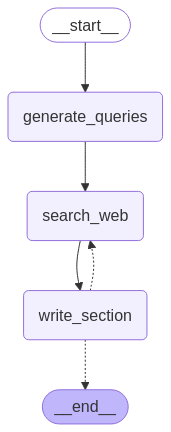

In [32]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

#section_builder.compile()
display(
    Image(
        section_builder.compile().get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

# Create a unique thread ID

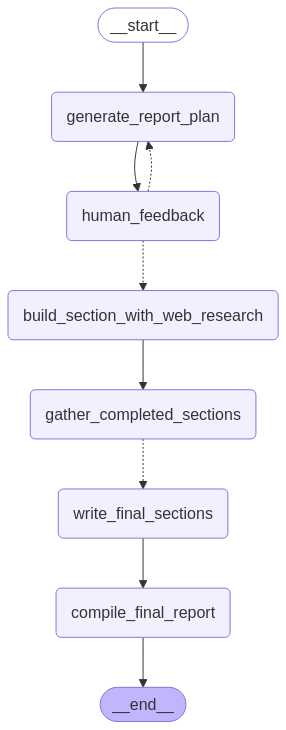

In [35]:
display(
    Image(
        graph_with_checkpoint.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [36]:
# Create a unique thread ID
import uuid
thread_id = str(uuid.uuid4())

# Start the graph execution with the topic and display the final report when it appears
async def run_graph_and_show_report():
    """Run the graph and display the final report when it appears"""
    async for chunk in graph_with_checkpoint.astream(
        {"topic": "DeepSeek-R1"}, 
        {"configurable": {"thread_id": thread_id}},
        stream_mode="updates"
    ):
        print(chunk)
        print("\n")
        
        # Check if this chunk contains the final_report
        if isinstance(chunk, dict) and 'final_report' in chunk:
            print("🎉 Final report generated! 🎉")
            display(Markdown(f"# DeepSeek-R1 Report\n\n{chunk['final_report']}"))
            return
        
        # Check if this is an interrupt that needs user feedback
        if isinstance(chunk, dict) and '__interrupt__' in chunk:
            interrupt_value = chunk['__interrupt__'][0].value
            display(Markdown(f"**Feedback Request:**\n{interrupt_value}"))
            return  # Stop execution to allow user to provide feedback

# Run the graph
await run_graph_and_show_report()

{'generate_report_plan': {'sections': [Section(name='Introduction to DeepSeek-R1', description="Brief overview of DeepSeek-R1, introducing it as an advanced AI reasoning model developed by DeepSeek, a Chinese AI company. This section will set the stage for understanding the model's significance in the AI landscape.", research=False, content=''), Section(name='Technical Architecture and Capabilities', description="Detailed exploration of DeepSeek-R1's technical specifications, including its 671B parameter Mixture-of-Experts (MoE) architecture with 37B activated parameters per token, and its focus on reasoning capabilities. Will cover context window size and processing capabilities.", research=True, content=''), Section(name='Performance Benchmarks and Achievements', description="Analysis of DeepSeek-R1's performance on key benchmarks such as MMLU, MMLU-Pro, GPQA, and IFEval. Highlights its exceptional mathematical capabilities, including its 97.3% score on the MATH-500 test, exceeding s

**Feedback Request:**
Please provide feedback on the following report plan. 
                        

Section: Introduction to DeepSeek-R1
Description: Brief overview of DeepSeek-R1, introducing it as an advanced AI reasoning model developed by DeepSeek, a Chinese AI company. This section will set the stage for understanding the model's significance in the AI landscape.
Research needed: No


Section: Technical Architecture and Capabilities
Description: Detailed exploration of DeepSeek-R1's technical specifications, including its 671B parameter Mixture-of-Experts (MoE) architecture with 37B activated parameters per token, and its focus on reasoning capabilities. Will cover context window size and processing capabilities.
Research needed: Yes


Section: Performance Benchmarks and Achievements
Description: Analysis of DeepSeek-R1's performance on key benchmarks such as MMLU, MMLU-Pro, GPQA, and IFEval. Highlights its exceptional mathematical capabilities, including its 97.3% score on the MATH-500 test, exceeding some competing models.
Research needed: Yes


Section: Comparison with Competitors
Description: Direct comparison between DeepSeek-R1 and other leading AI models, particularly OpenAI's o1 series. Will examine strengths and weaknesses in areas such as coding, factual reasoning, and cost-efficiency.
Research needed: Yes


Section: Open-Source Nature and Market Impact
Description: Exploration of DeepSeek-R1's open-source status under the MIT license, its implications for developers and businesses, and its impact on the global AI market. Will include information about API access and pricing considerations.
Research needed: Yes


Section: Conclusion: The Future of DeepSeek-R1
Description: Summary of DeepSeek-R1's significance in the evolution of AI models, highlighting key takeaways about its capabilities, advantages, and position in the market. Will include a comprehensive table comparing DeepSeek-R1's key features with competitors.
Research needed: No



                        
Does the report plan meet your needs? Pass 'true' to approve the report plan or provide feedback to regenerate the report plan:

In [37]:
async def approve_plan():
    """Approve the plan and continue execution"""
    max_retries = 5  # Increased from 3 to 5
    base_delay = 15  # Increased from 5 to 15 seconds
    
    for attempt in range(max_retries):
        try:
            # Use a more conservative approach with longer delays between retries
            if attempt > 0:
                wait_time = base_delay * (2 ** attempt)
                print(f"Waiting {wait_time} seconds before retry {attempt+1}/{max_retries}...")
                await asyncio.sleep(wait_time)
            
            print(f"Attempt {attempt+1}/{max_retries} to resume execution...")
            
            # Set a timeout for the stream operation
            async with asyncio.timeout(300):  # 5-minute timeout
                async for chunk in graph_with_checkpoint.astream(
                    Command(resume=True), 
                    {
                        "configurable": {
                            "thread_id": thread_id,
                            # Add configuration to reduce token usage
                            "max_tokens_per_call": 1000,  # Limit tokens per call
                            "thinking": {"enabled": {"budget_tokens": 4096}}  # Set thinking budget
                        }
                    },
                    stream_mode="updates"
                ):
                    print(chunk)
                    print("\n")
                    
                    # Check if this chunk contains the compile_final_report with final_report
                    if isinstance(chunk, dict) and 'compile_final_report' in chunk:
                        if 'final_report' in chunk['compile_final_report']:
                            print("🎉 Final report generated! 🎉")
                            final_report = chunk['compile_final_report']['final_report']
                            display(Markdown(f"# DeepSeek-R1 Report\n\n{final_report}"))
                            return
                            
                    # Also check for final_report at the top level
                    if isinstance(chunk, dict) and 'final_report' in chunk:
                        print("🎉 Final report generated! 🎉")
                        display(Markdown(f"# DeepSeek-R1 Report\n\n{chunk['final_report']}"))
                        return
                
                # If we get here without returning, it means the stream completed without a final report
                print("Stream completed without generating a final report.")
                return
                
        except asyncio.TimeoutError:
            print(f"Operation timed out on attempt {attempt+1}. Retrying...")
            continue
        except Exception as e:
            error_str = str(e)
            if "rate_limit_error" in error_str and attempt < max_retries - 1:
                wait_time = base_delay * (2 ** attempt)
                print(f"Rate limit exceeded. Retrying in {wait_time} seconds... (Attempt {attempt+1}/{max_retries})")
                await asyncio.sleep(wait_time)
            elif "thinking.enabled.budget_tokens" in error_str and attempt < max_retries - 1:
                print(f"Thinking budget error detected. Retrying in 10 seconds... (Attempt {attempt+1}/{max_retries})")
                await asyncio.sleep(10)
            elif attempt < max_retries - 1:
                # Handle any other errors with retry
                print(f"Error during execution: {error_str}")
                print(f"Retrying in {base_delay} seconds... (Attempt {attempt+1}/{max_retries})")
                await asyncio.sleep(base_delay)
            else:
                print(f"Error during execution after {max_retries} attempts: {error_str}")
                raise

In [38]:
async def provide_feedback(feedback_text):
    """Provide feedback and continue execution"""
    async for chunk in graph_with_checkpoint.astream(
        Command(resume=feedback_text), 
        {"configurable": {"thread_id": thread_id}},
        stream_mode="updates"
    ):
        print(chunk)
        print("\n")
        
        # Check if this chunk contains the final_report
        if isinstance(chunk, dict) and 'final_report' in chunk:
            print("🎉 Final report generated! 🎉")
            display(Markdown(f"# DeepSeek-R1 Report\n\n{chunk['final_report']}"))
            return

> NOTE: You *can* choose to continue the flow - though the notebook implementation will require you to stretch your coding muscles a bit!

In [39]:
await approve_plan()

Attempt 1/5 to resume execution...
{'human_feedback': None}


{'build_section_with_web_research': {'completed_sections': [Section(name='Performance Benchmarks and Achievements', description="Analysis of DeepSeek-R1's performance on key benchmarks such as MMLU, MMLU-Pro, GPQA, and IFEval. Highlights its exceptional mathematical capabilities, including its 97.3% score on the MATH-500 test, exceeding some competing models.", research=True, content="## Performance Benchmarks and Achievements\n\n**DeepSeek-R1 demonstrates exceptional mathematical and reasoning capabilities, notably achieving a 97.3% score on MATH-500, surpassing OpenAI's o1-1217 at 96.4%**. The model shows strong performance across multiple benchmark categories:\n\n* Mathematical Reasoning: 79.8% on AIME 2024, exceeding o1-1217's 79.2%\n* Coding Proficiency: 96.3% percentile on Codeforces, nearly matching o1-1217's 96.6%\n* General Knowledge: 90.8% on MMLU, approaching o1-1217's 91.8%\n* Scientific Reasoning: 71.5% on GPQA 

# DeepSeek-R1 Report

# DeepSeek-R1

DeepSeek-R1 represents a significant advancement in AI reasoning capabilities, combining powerful performance with unprecedented accessibility. Developed by Chinese AI company DeepSeek, this model employs an innovative 671B parameter Mixture-of-Experts architecture that activates only 37B parameters per token, enabling state-of-the-art performance while maintaining practical computational requirements. The model's release under an MIT license, coupled with its exceptional mathematical and coding capabilities, marks a pivotal moment in democratizing access to advanced AI technology while challenging established market dynamics through competitive pricing and open-source availability.

## Technical Architecture and Capabilities

**DeepSeek-R1's innovative architecture combines massive scale with efficient parameter activation, enabling advanced reasoning while maintaining practical computational requirements.** The model employs a 671B parameter Mixture-of-Experts (MoE) architecture that activates only 37B parameters per token, dramatically reducing computational overhead compared to traditional architectures.

Key technical capabilities include:

- 128K token context window for handling complex multi-step reasoning
- Multi-head Latent Attention (MLA) for efficient memory management
- Group Relative Policy Optimization (GRPO) for balanced expert utilization
- Auxiliary-loss-free load balancing system with dynamic expert bias
- Multi-token prediction training objective for enhanced performance

DeepSeek-R1 achieves this efficiency through careful co-design of algorithms, frameworks, and hardware. For example, its DualPipe parallelism system overlaps computation with MoE dispatch operations, while FP8 mixed precision reduces memory requirements. The model demonstrates strong performance across reasoning tasks while requiring only 2.788M H800 GPU hours for training on 14.8T tokens.

### Sources
- DeepSeek-R1 - AI Model Details: https://docsbot.ai/models/deepseek-r1
- The DeepSeek Series: A Technical Overview: https://martinfowler.com/articles/deepseek-papers.html
- [2412.19437] DeepSeek-V3 Technical Report: https://arxiv.org/abs/2412.19437
- Understanding DeepSeek-R1: A Deep Dive into its Capabilities and Challenges: https://fanyangmeng.blog/understanding-deepseek-r1/

## Performance Benchmarks and Achievements

**DeepSeek-R1 demonstrates exceptional mathematical and reasoning capabilities, notably achieving a 97.3% score on MATH-500, surpassing OpenAI's o1-1217 at 96.4%**. The model shows strong performance across multiple benchmark categories:

* Mathematical Reasoning: 79.8% on AIME 2024, exceeding o1-1217's 79.2%
* Coding Proficiency: 96.3% percentile on Codeforces, nearly matching o1-1217's 96.6%
* General Knowledge: 90.8% on MMLU, approaching o1-1217's 91.8%
* Scientific Reasoning: 71.5% on GPQA Diamond

A notable case study is DeepSeek-R1's performance on the LiveCodeBench, where it achieved 65.9% pass@1, significantly outperforming competitors like Claude 3.5 Sonnet (38.9%) and GPT-4 (32.9%). This demonstrates its practical coding capabilities.

The model's achievements are particularly impressive given its cost efficiency, operating at approximately 95% lower cost than competing models. However, evaluations reveal some limitations in factual accuracy, with a higher hallucination rate of 14.3% compared to DeepSeek-V3's 3.9%.

### Sources
- DeepSeek R1 Capabilities in Detail : https://www.aisharenet.com/en/deepseek-r1nenglixiang/
- DeepSeek R1: A New Era in Open-Source AI Performance : https://consensuslabs.ch/blog/deepseek-r1-open-source-ai-benchmark-comparison
- Understanding DeepSeek-R1: A Deep Dive into its Capabilities and Challenges : https://fanyangmeng.blog/understanding-deepseek-r1/

## Comparison with Competitors

**DeepSeek-R1 achieves comparable performance to leading models like OpenAI's o1 while offering significant cost advantages, with API costs approximately 96% lower at $0.55 per million input tokens versus o1's $15.00.**

The model demonstrates strong mathematical reasoning capabilities, scoring 97.3% on MATH-500 compared to o1's 96.4%. For coding tasks, both models show expert-level performance, with DeepSeek-R1 achieving 96.3 percentile ranking on Codeforces versus o1's 96.6%.

A key architectural difference lies in DeepSeek-R1's use of Mixture-of-Experts (MoE), which activates only 37 billion of its 671 billion parameters per token, enabling efficient processing. This contrasts with o1's traditional dense architecture focused on comprehensive reasoning tokens.

Key performance differences:
* Processing Speed: DeepSeek-R1 averages 2.4x faster response times
* Context Window: o1 supports 200K tokens vs R1's 128K tokens
* Cost Efficiency: DeepSeek-R1 charges $0.55 per million input tokens vs o1's $15.00
* General Knowledge: o1 scores slightly higher on MMLU (91.8% vs 90.8%)

### Sources
- DeepSeek R1 vs. all: A Real, Thorough and Hollistic Comparison : https://medium.com/@seguigomezolea/deepseek-r1-vs-google-gemini-vs-openai-gpt-4-and-others-a-real-comparison-07f157d5cb9f
- DeepSeek R1: Features, o1 Comparison, Distilled Models & More : https://www.datacamp.com/blog/deepseek-r1
- DeepSeek-R1: Intelligence, Performance & Price Analysis : https://artificialanalysis.ai/models/deepseek-r1

## Open-Source Nature and Market Impact

**DeepSeek-R1's MIT license represents a significant shift in AI model accessibility, making it one of the first high-performance reasoning models freely available for commercial use and modification.**

The model's open-source status allows developers to examine, modify, and redistribute both the code and model weights without restriction. This contrasts with other major AI models that typically have restrictive licenses or are closed-source. The MIT license specifically enables:

* Commercial usage without registration
* Model weight modifications and redistribution
* Development of derivative models
* Unrestricted fine-tuning and distillation

DeepSeek offers two primary access methods: a free web interface with a 50-message daily limit, and an API with competitive pricing. The API costs are notably lower than competitors, with rates of $0.14 per million input tokens (cache hit), $0.55 per million input tokens (cache miss), and $2.19 per million output tokens.

This pricing structure has created market pressure on established providers, particularly affecting companies like OpenAI that charge significantly higher rates. The model's performance matching OpenAI's o1 while maintaining lower costs has already influenced market dynamics and stock valuations in the AI sector.

### Sources
- DeepSeek API by PiAPI: https://piapi.ai/deepseek
- DeepSeek-R1 Release | DeepSeek API Docs: https://api-docs.deepseek.com/news/news250120
- GrainForge/DeepSeek-R1: https://github.com/GrainForge/DeepSeek-R1
- What DeepSeek Really Changes About AI Competition | RAND: https://www.rand.org/pubs/commentary/2025/02/what-deepseek-really-changes-about-ai-competition.html

## The Future of DeepSeek-R1

DeepSeek-R1 represents a pivotal advancement in AI development, combining exceptional performance with unprecedented accessibility. Its 671B parameter MoE architecture delivers near-parity with leading proprietary models while dramatically reducing computational costs. The model's MIT license and competitive pricing structure have already begun reshaping market dynamics, challenging established providers to reconsider their pricing strategies.

| Feature | DeepSeek-R1 | OpenAI o1 |
|---------|-------------|------------|
| Parameters | 671B (37B active) | Not disclosed |
| Context Window | 128K tokens | 200K tokens |
| MATH-500 Score | 97.3% | 96.4% |
| MMLU Score | 90.8% | 91.8% |
| Input Token Cost | $0.55/M | $15.00/M |
| License | MIT Open-source | Proprietary |

As the AI landscape evolves, DeepSeek-R1's combination of performance, efficiency, and accessibility positions it as a catalyst for democratizing advanced AI capabilities. Its success suggests a future where high-performance AI models become increasingly accessible to developers and businesses worldwide, potentially accelerating innovation across the entire field.